# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle
import cupy as cp

# Data Fetching

In [2]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16],low_memory=False)
    out= pd.read_csv('data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19],low_memory=False)
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [3]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(A1)
Y1=scaler_obj.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

# Parameter Tuning

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [7,8,10,],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'n_estimators' : [80,90,100,200,400,1000],
        'objective': ['reg:squarederror','count:poisson']
    }

    xgb_model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)

    gsearch = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_tuning, n_iter = 5, cv = 2, verbose=2, random_state=0, n_jobs = -1)

    
    grid_result = MultiOutputRegressor(gsearch).fit(x_train, y_train)

    return grid_result.estimators_[0].best_params_

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=0)

params=hyperParameterTuning(x_train,y_train)
params

# Model

In [4]:
# Splitting Data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=0)

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

#creating object of sgboostregressor
model1=MultiOutputRegressor(XGBRegressor(tree_method='gpu_hist', gpu_id=0,objective='count:poisson',max_depth=10,learning_rate=0.1,min_child_weight=3,
                   n_estimators=400,subsample=0.9))

#training the model
model_fit1=model1.fit(x_train, y_train)
print("Model training is Done!!")

#saving as file
filename1 = 'xgboost.sav'
pickle.dump(model_fit1, open(filename1, 'wb'))

Model training is Done!!


# Error Analysis

In [5]:
from sklearn.metrics import r2_score
from sklearn import metrics
train_sizes=['NO2','O3','NO','CO','PM1','PM2.5','PM10']

#finding out the r2 score
y_train_pred1=model1.predict(x_train)
r2_train1=r2_score(y_train,y_train_pred1)

y_test_pred1=model1.predict(x_test)
r2_test1=r2_score(y_test,y_test_pred1)

print('r2 score on train data '+str(r2_train1))
print('r2 score on test data '+ str(r2_test1))

xgboost_mae=metrics.mean_absolute_error(y_test, y_test_pred1)
xgboost_mse=metrics.mean_squared_error(y_test, y_test_pred1)
xgboost_rmse=np.sqrt(xgboost_mse)
print('Mean Absolute Error:',xgboost_mae)
print('Mean Squared Error:',xgboost_mse )
print('Root Mean Squared Error:',xgboost_rmse)
print(' \n')

r2 score on train data 0.5255211115086744
r2 score on test data 0.5147449313479925
Mean Absolute Error: 0.0007392266
Mean Squared Error: 8.095928e-06
Root Mean Squared Error: 0.0028453344
 



# y-test vs y-predict

Y_Test: [[0.00010812 0.06553657 0.0001368  ... 0.00465421 0.0032433  0.00139601]
 [0.00011141 0.06553698 0.0001189  ... 0.00947999 0.00574444 0.00183423]
 [0.00011193 0.0655366  0.0001198  ... 0.03056333 0.01916761 0.00634215]
 ...
 [0.0001126  0.06553672 0.00011279 ... 0.01996804 0.01252907 0.00401423]
 [0.00011253 0.06553655 0.00012397 ... 0.03575373 0.02222976 0.00729255]
 [0.000112   0.06553673 0.00011786 ... 0.00466493 0.00372249 0.0052013 ]]
Y_Test_Predict: [[0.00010843 0.0655368  0.0001346  ... 0.0029274  0.00197738 0.00099313]
 [0.00011098 0.06553682 0.00012142 ... 0.0151221  0.01010753 0.00439391]
 [0.0001116  0.0655368  0.00011702 ... 0.03117023 0.01920055 0.00683572]
 ...
 [0.00012457 0.0655368  0.00011456 ... 0.02238273 0.01399931 0.00507025]
 [0.0001131  0.06553661 0.00012244 ... 0.03499362 0.02223811 0.00681929]
 [0.00011158 0.0655368  0.00011897 ... 0.00597724 0.00383696 0.00317179]]


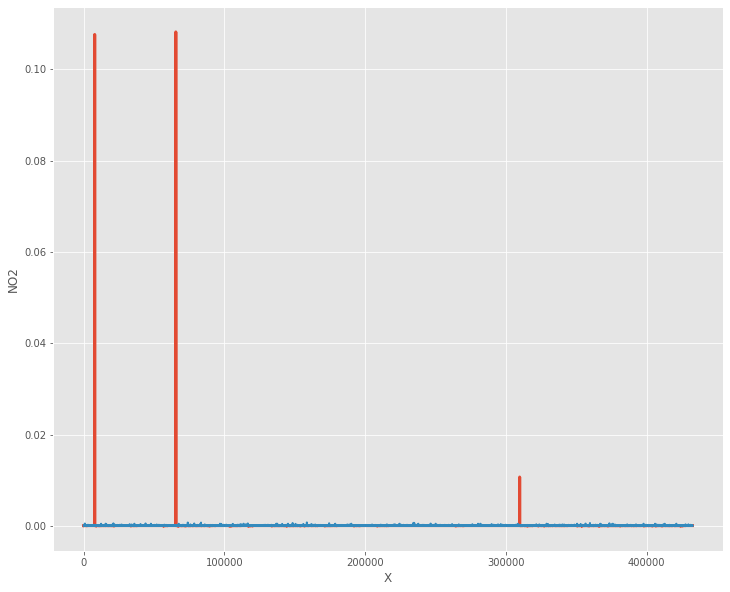

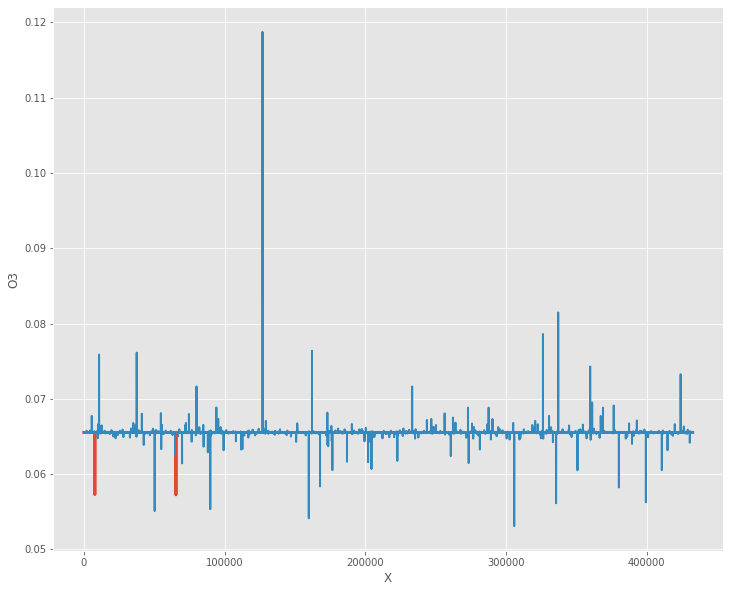

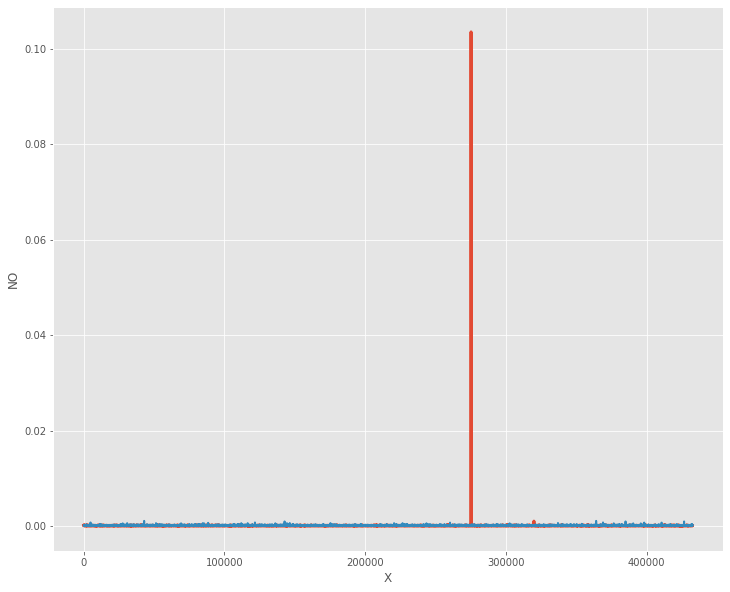

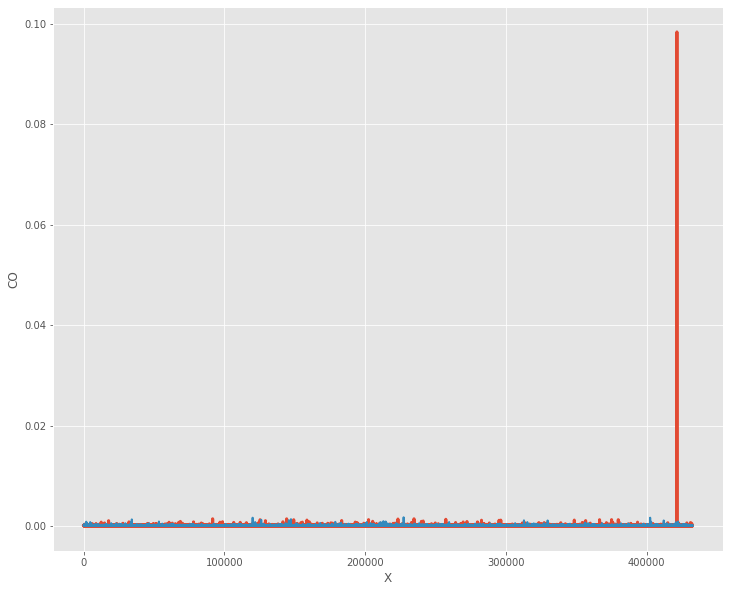

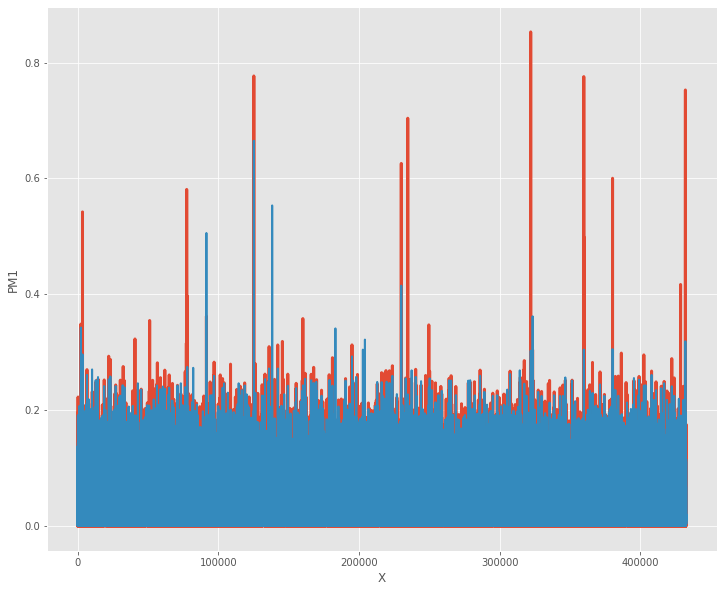

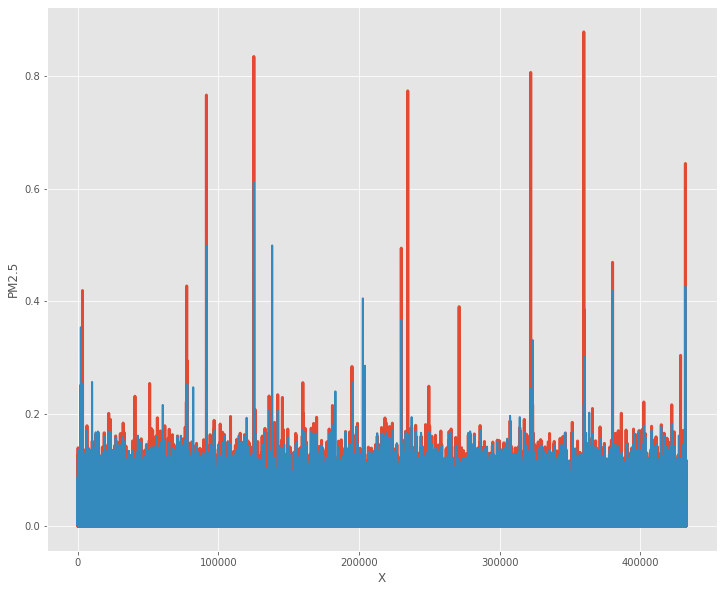

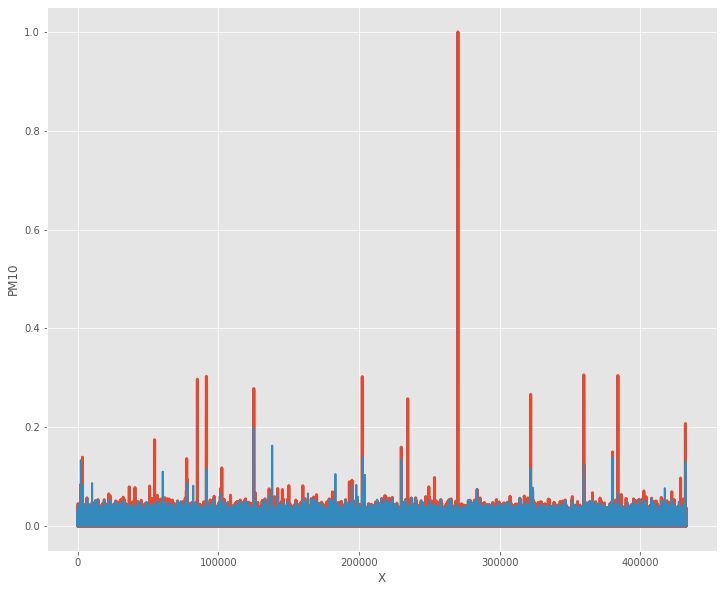

In [6]:
# printing y_test and y_test_predict
print("Y_Test:",y_test)
print("Y_Test_Predict:",y_test_pred1)

from matplotlib import style

style.use('ggplot')

for i in range(0,7):
  plt.figure(figsize=[12,10])
  plt.plot(y_test[:,i],linewidth=3, markersize=12)
  plt.plot(y_test_pred1[:,i],linewidth=2, markersize=12)
  plt.xlabel('X')
  plt.ylabel(train_sizes[i])
  plt.show()